In [1]:
include("../src/lib/readconfig.jl");
config = readconfig("../configs/complete.yml")
config["startmonth"] = "1/1950"
config["timestep"] = 12;

In [2]:
include("../src/world.jl");
include("../src/weather.jl");

Loading from saved region network...


  likely near /Users/jrising/.julia/v0.4/Graphs/src/common.jl:3
  likely near /Users/jrising/.julia/v0.4/Graphs/src/dot.jl:80


Loading from saved water network...


In [10]:
include("../src/UnivariateAgriculture.jl");

Loading from saved region network...


In [11]:
model = newmodel();
agriculture = initunivariateagriculture(model);
run(model);

In [5]:
fipsmapping = readtable(datapath("agriculture/allyears/Master_Spreadsheet_All.csv"));

In [12]:
dfbycy = DataFrame(crop=String[], fips=String[], year=Int64[], obsyield=Float64[], estyield=Float64[], obsprod=Float64[], estprod=Float64[])
cropunits = Dict{String, String}()
for cc in 1:length(allcrops)
    crop = allcrops[cc]
    println(crop)
    prodpath = findcroppath("agriculture/allyears/", crop, "_production_in_bu.csv")
    cropunits[crop] = "bu"
    if prodpath == nothing
        prodpath = findcroppath("agriculture/allyears/", crop, "_production_in_lb.csv")
        cropunits[crop] = "lb"
    end
    areapath = findcroppath("agriculture/allyears/", crop, "_area_planted_in_acre.csv")
    areacolumn = "AREA_PLANTED_"
    if areapath == nothing
        areapath = findcroppath("agriculture/allyears/", crop, "_area_harvested_in_acre.csv")
        areacolumn = "AREA_HARVESTED_"
    end
    obsprods = readtable(prodpath)
    obsareas = readtable(areapath)
    estprods = model[:UnivariateAgriculture, :production][:, cc, :]
    estyields = model[:UnivariateAgriculture, :yield2][:, cc, :]
    for ii in 1:nrow(masterregions) #[1318]
        if ii % 300 == 0
            println(ii)
        end
        fidrows = fipsmapping[:, :FIPS] .== parse(Int64, masterregions[ii, :fips]);
        if sum(fidrows) == 1
            fid = fipsmapping[fidrows, :FID][1]
            for year in 1950:2010
                obsprod = obsprods[obsprods[:cnty_FID] .== fid, symbol("PRODUCTION_$year")]
                obsarea = obsareas[obsareas[:cnty_FID] .== fid, symbol("$areacolumn$year")]
                estprod = estprods[ii, 1, year - 1950 + 1]
                estyield = estyields[ii, 1, year - 1950 + 1]
                if !isna(obsprod[1])
                    push!(dfbycy, [crop masterregions[ii, :fips] year obsprod[1]/obsarea[1] estyield obsprod estprod])
                end
            end
        end
    end
end

barley
300
600
900
1200
1500
1800
2100
2400
2700
3000
corn
300
600
900
1200
1500
1800
2100
2400
2700
3000
sorghum
300
600
900
1200
1500
1800
2100
2400
2700
3000
soybeans
300
600
900
1200
1500
1800
2100
2400
2700
3000
wheat
300
600
900
1200
1500
1800
2100
2400
2700
3000
hay
300
600
900
1200
1500
1800
2100
2400
2700
3000


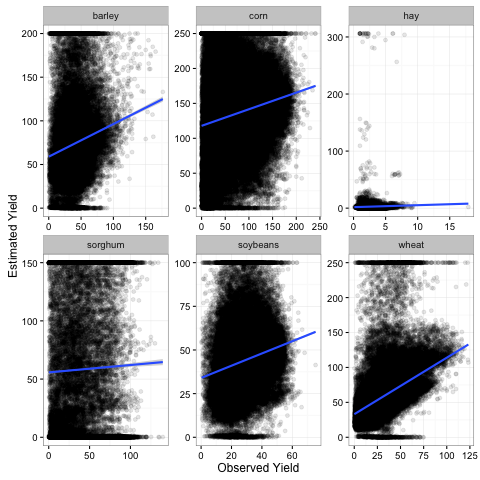

RCall.RObject{RCall.VecSxp}


In [13]:
using RCall
RCall.ijulia_setdevice(MIME("image/png"),width=8*72,height=5*72)
R"library(ggplot2)"
R"ggplot($dfbycy, aes(obsyield, estyield)) + facet_wrap(~ crop, scales=\"free\") + geom_point(alpha=.1) + geom_smooth(method = \"lm\") + xlab(\"Observed Yield\") + ylab(\"Estimated Yield\") + theme_bw()"

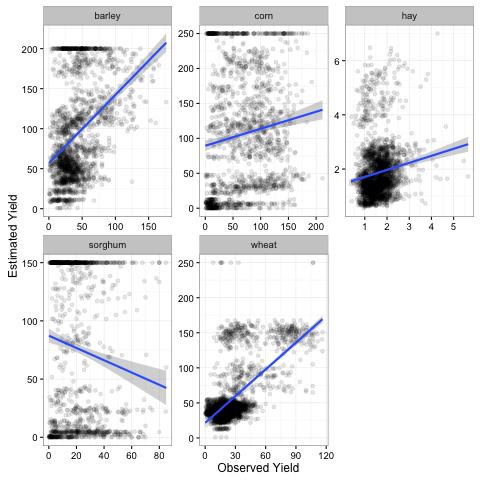

RCall.RObject{RCall.VecSxp}


In [14]:
codf = dfbycy[map(fips -> fips[1:2], dfbycy[:fips]) .== "08",:]
R"library(ggplot2)"
R"ggplot($codf, aes(obsyield, estyield)) + facet_wrap(~ crop, scales=\"free\") + geom_point(alpha=.1) + geom_smooth(method = \"lm\") + xlab(\"Observed Yield\") + ylab(\"Estimated Yield\") + theme_bw()"

In [22]:
dfbyy = DataFrame(fips=String[], year=Int64[], obsirrig=Float64[], estirrig=Float64[])

obsirrigs = readtable("../data/counties/extraction/allyear_irrigation.csv")
estirrigs = model[:UnivariateAgriculture, :totalirrigation]

for ii in 1:nrow(masterregions)
    if ii % 300 == 0
        println(ii)
    end
    for year in 1985:5:2010
        obsirrig = obsirrigs[obsirrigs[:FIPS] .== parse(Int64, masterregions[ii, :fips]), symbol("IR_To_$year")] * 1381.6753 # Mgal/d to 1000 m^3
        estirrig = estirrigs[ii, year - 1950 + 1]
        push!(dfbyy, [masterregions[ii, :fips] year obsirrig estirrig])
    end
end

300
600
900
1200
1500
1800
2100
2400
2700
3000


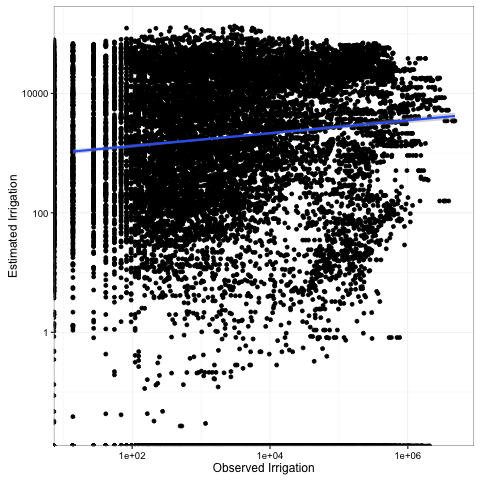

RCall.RObject{RCall.VecSxp}


In [26]:
using RCall
RCall.ijulia_setdevice(MIME("image/png"),width=8*72,height=5*72)
R"library(ggplot2)"
R"ggplot($dfbyy, aes(obsirrig, estirrig)) + geom_point() + geom_smooth(method = \"lm\") + xlab(\"Observed Irrigation\") + ylab(\"Estimated Irrigation\") + theme_bw() + scale_x_log10() + scale_y_log10()"

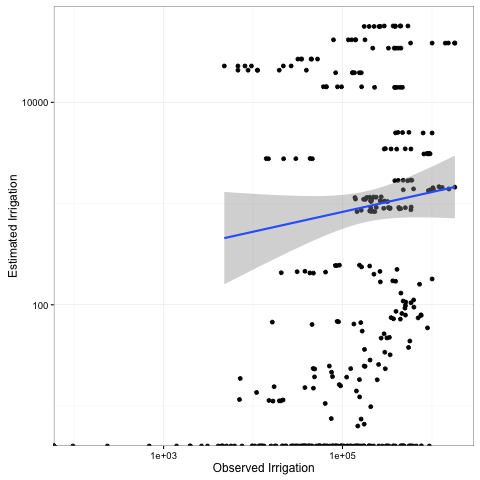

RCall.RObject{RCall.VecSxp}


In [27]:
codf = dfbyy[map(fips -> fips[1:2], dfbyy[:fips]) .== "08",:]
R"library(ggplot2)"
R"ggplot($codf, aes(obsirrig, estirrig)) + geom_point() + geom_smooth(method = \"lm\") + xlab(\"Observed Irrigation\") + ylab(\"Estimated Irrigation\") + theme_bw() + scale_x_log10() + scale_y_log10()"